In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

In [3]:
START_DATE = '2022-12-12'
END_DATE = '2023-02-12'
DATE_RANGE = pd.date_range(START_DATE, END_DATE)

In [4]:
# Read db file
df = pd.read_csv('DBSS_SNOC_ACTIVATIONLOG.csv')
# Filter columns
df = df[["CODE_PDV", "DATE_DERNIERE_MODIFICATION"]]

C:\Users\aymen\AppData\Local\Temp\ipykernel_6444\2762357769.py:2: DtypeWarning: Columns (2,6,20,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('DBSS_SNOC_ACTIVATIONLOG.csv')


In [5]:
def getPdv(_df, code_pdv):
    pdv_df = pd.DataFrame(_df[_df["CODE_PDV"] == code_pdv])
    temp = pd.DataFrame()
    temp['DATE_DERNIERE_MODIFICATION'] = pdv_df['DATE_DERNIERE_MODIFICATION']
    temp['DATE_DERNIERE_MODIFICATION'] = temp['DATE_DERNIERE_MODIFICATION'].apply(lambda str: str.split(' ')[0])
    pdv_df['DATE_DERNIERE_MODIFICATION'] = pd.to_datetime(temp['DATE_DERNIERE_MODIFICATION'], yearfirst=False, format="%d/%m/%Y")
    pdv_df = pdv_df[pdv_df['DATE_DERNIERE_MODIFICATION'] <= END_DATE]
    pdv_df = pdv_df[pdv_df['DATE_DERNIERE_MODIFICATION'] >= START_DATE]
    pdv_df.drop(['CODE_PDV'], axis=1, inplace=True)
    return pdv_df

In [6]:
def getOverall(_df):
    getOverall_df = _df.copy()
    temp = pd.DataFrame()
    temp['DATE_DERNIERE_MODIFICATION'] = getOverall_df['DATE_DERNIERE_MODIFICATION']
    temp['DATE_DERNIERE_MODIFICATION'] = temp['DATE_DERNIERE_MODIFICATION'].apply(lambda str: str.split(' ')[0])
    getOverall_df['DATE_DERNIERE_MODIFICATION'] = pd.to_datetime(temp['DATE_DERNIERE_MODIFICATION'], yearfirst=False, format="%d/%m/%Y", errors='raise')
    getOverall_df = getOverall_df[getOverall_df['DATE_DERNIERE_MODIFICATION'] <= END_DATE]
    getOverall_df = getOverall_df[getOverall_df['DATE_DERNIERE_MODIFICATION'] >= START_DATE]
    getOverall_df.drop(['CODE_PDV'], axis=1, inplace=True)
    return getOverall_df

In [7]:
def getTransactions(_df):
    return _df['DATE_DERNIERE_MODIFICATION'].value_counts()

In [8]:
def getPdvData(_df, code_pdv):
    df1 = pd.DataFrame(getTransactions(getPdv(_df, code_pdv)))
    df1.columns = ['Transactions']
    df1.index = pd.to_datetime(df1.index)
    new_rows = list(set(DATE_RANGE) - set(df1.index.to_list()))
    for date in new_rows:
        df1.loc[date] = [0] * len(df1.columns)
        
    df1 = df1.sort_index().fillna(0)
    return df1

In [9]:
def getOverallData(_df):
    df1 = pd.DataFrame(getTransactions(getOverall(_df)))
    df1.columns = ['Transactions']
    df1.index = pd.to_datetime(df1.index)
    new_rows = list(set(DATE_RANGE) - set(df1.index.to_list()))
    for date in new_rows:
        df1.loc[date] = [0] * len(df1.columns)
        
    df1 = df1.sort_index().fillna(0)
    return df1

In [10]:
def plot(_df, title='Number of SNOC transactions per day'):
    print(_df.describe().transpose())
    plt.figure(figsize=(10,5))
    time_series = _df['Transactions']
    time_series.rolling(7).mean().plot(label='7 Days rolling mean')
    time_series.rolling(7).std().plot(label='7 Days rolling std')
    time_series.plot()
    plt.legend()
    plt.title(title)
    plt.xlabel('Days')
    plt.ylabel('# of Transactions')

              count          mean          std     min      25%      50%  \
Transactions   63.0  15664.587302  3582.439265  6933.0  14621.5  15848.0   

                  75%      max  
Transactions  16863.0  23693.0  


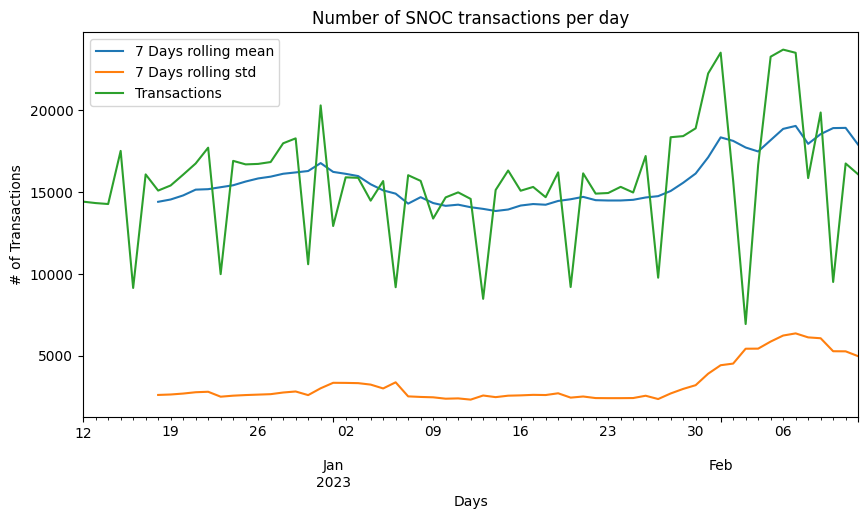

In [11]:
overall1 = getOverallData(df)
plot(overall1)

In [12]:
transactions = overall1['Transactions']
type(transactions)

pandas.core.series.Series

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [14]:
decomp = seasonal_decompose(transactions)

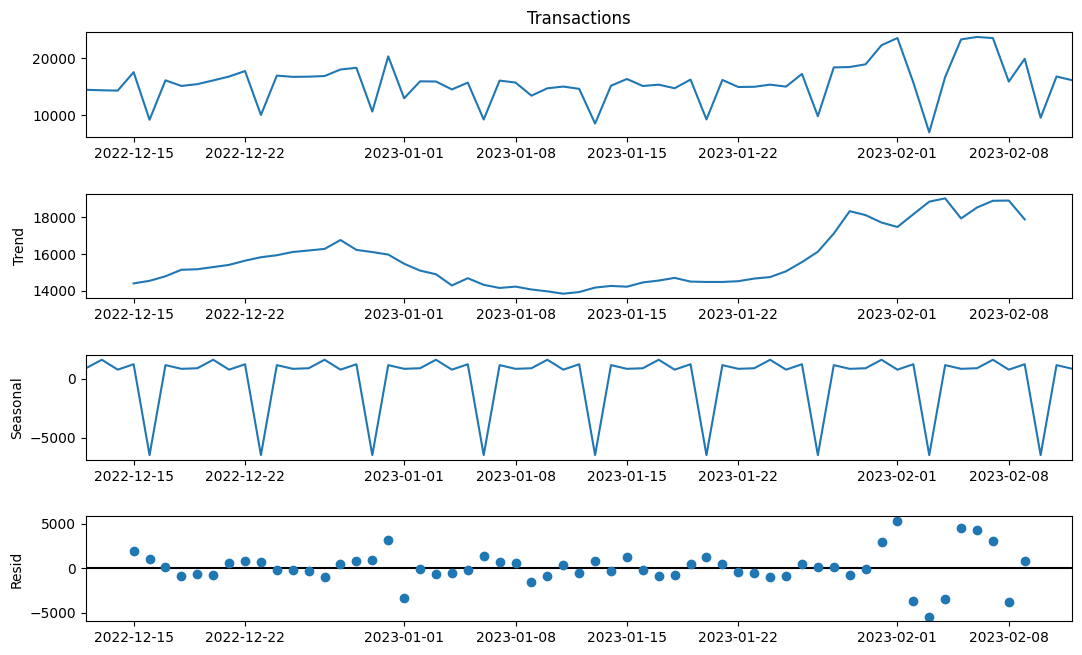

In [15]:
fig = decomp.plot()
fig.set_size_inches(12,7)

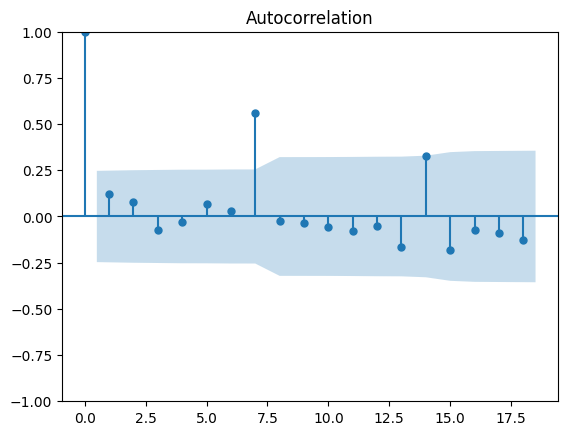

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
acf = plot_acf(transactions)

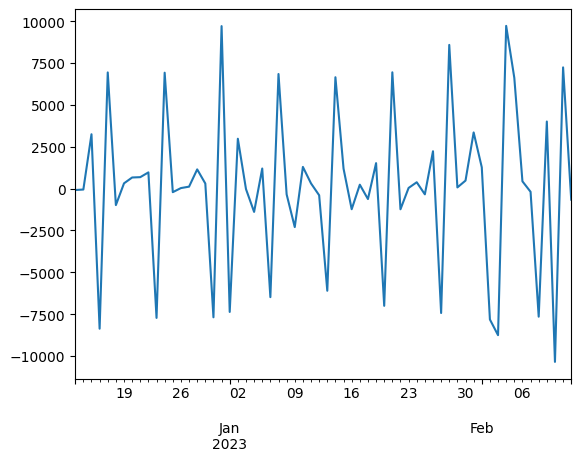

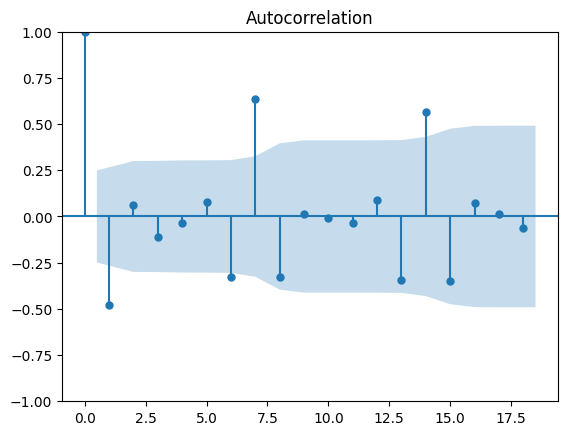

In [17]:
transactions_diff = transactions.diff(periods=1)[1:]
transactions_diff.plot()
acf = plot_acf(transactions_diff)

In [293]:
import math
import warnings
warnings.filterwarnings('ignore')

X = transactions
total_size = len(X)
train_size = math.floor(total_size * 0.95)
test_size = total_size - train_size
train_X, test_X = X[:train_size], X[train_size:] # 80% to train and 20% to test

models_stats = pd.DataFrame(columns=['Model', 'Mean Squared Error'])

# AR, ARIMA, SARIMA

## Autoregressing Model

In [294]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

model_ar = AutoReg(train_X, lags=7)
model_ar_fit = model_ar.fit()

In [295]:
test_preds = model_ar_fit.predict(start=train_size, end=len(X)-1)
models_stats = models_stats.append({'Model':'AR','Mean Squared Error': mean_squared_error(test_X, test_preds)}, ignore_index=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


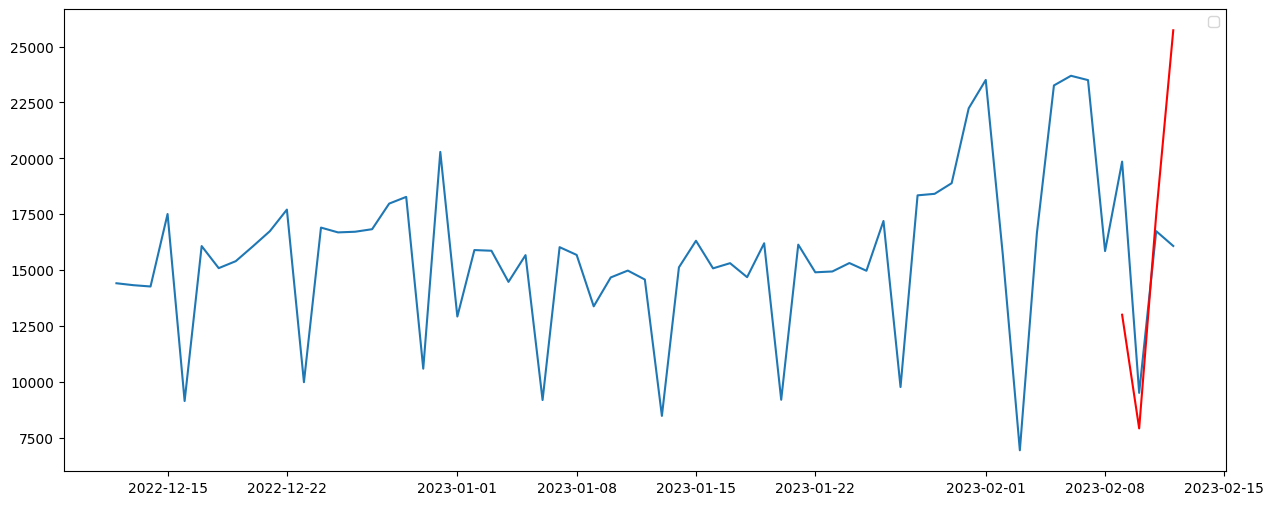

In [296]:
plt.figure(figsize=(15, 6))
plt.plot(X)
plt.plot(test_preds, color='red')
plt.legend()

## ARIMA model

In [297]:
import statsmodels.api as sm

import itertools
import warnings
warnings.filterwarnings('ignore')

p=d=q=range(0,5)
pdq = list(itertools.product(p, d, q))
min_aic, min_pdq = 2000, (0, 0, 0)

for param in pdq:
    try:
        model_arima = sm.tsa.arima.ARIMA(train_X, order=param)
        model_arima_fit = model_arima.fit()
        if(model_arima_fit.aic < min_aic):
            min_aic = model_arima_fit.aic
            min_pdq = param
    except:
        continue

min_aic, min_pdq

In [298]:
# (902.3203296793583, (4, 3, 4))
min_pdq = (4, 3, 4)
model_arima = sm.tsa.arima.ARIMA(train_X, order=min_pdq)
model_arima_fit = model_arima.fit()

In [299]:
test_preds = model_arima_fit.forecast(steps=test_size)
models_stats = models_stats.append({'Model':'ARIMA','Mean Squared Error': mean_squared_error(test_X, test_preds)}, ignore_index=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


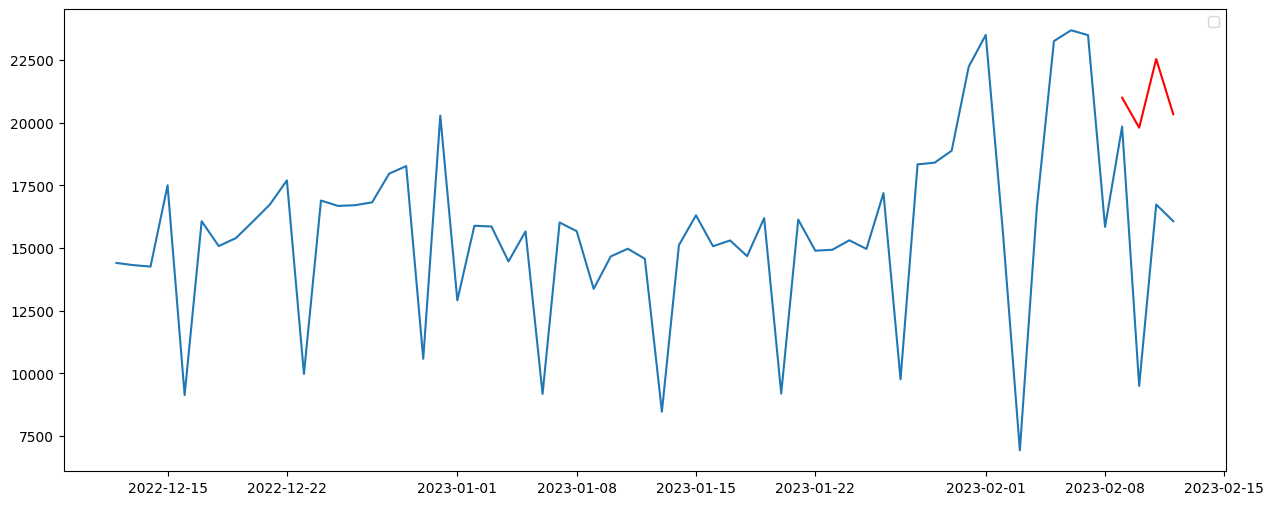

In [300]:
plt.figure(figsize=(15, 6))
plt.plot(X)
plt.plot(test_preds, color='red')
plt.legend()

## SARIMA Model

In [301]:
model_sarima = sm.tsa.SARIMAX(train_X, order=(1, 0, 1), seasonal_order=(1, 1, 1, 7))
model_sarima_fit = model_sarima.fit()
print(model_sarima_fit.aic)

973.2481265709539


In [302]:
test_preds = model_sarima_fit.forecast(steps=test_size)
models_stats = models_stats.append({'Model':'SARIMA','Mean Squared Error': mean_squared_error(test_X, test_preds)}, ignore_index=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


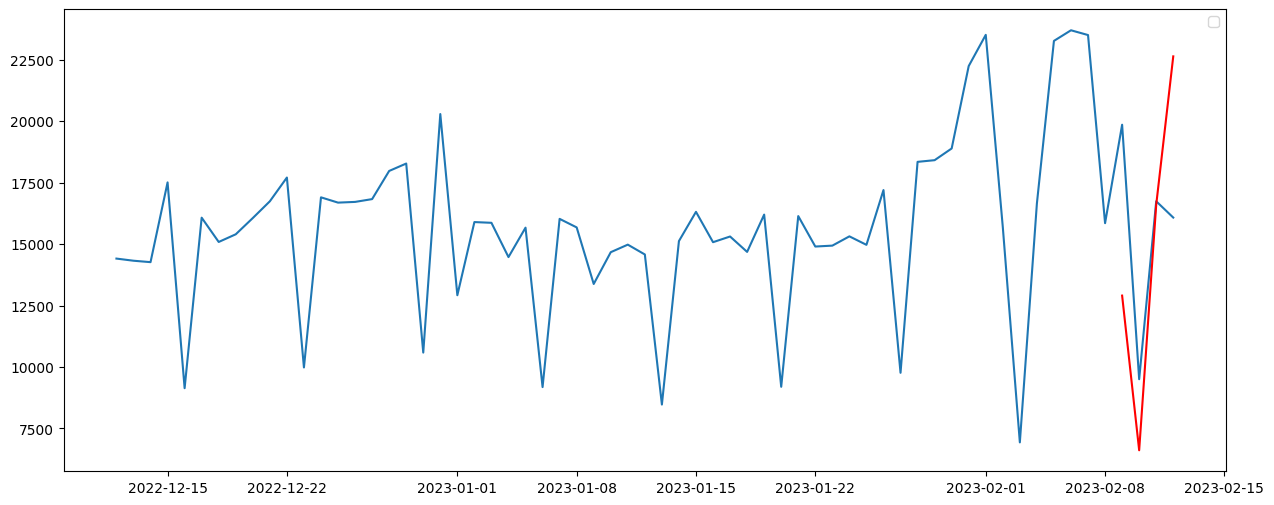

In [303]:
plt.figure(figsize=(15, 6))
plt.plot(X)
plt.plot(test_preds, color='red')
plt.legend()

# SARIMA 2

In [304]:
from pmdarima import auto_arima

In [305]:
model = auto_arima(y=train_X, m=7)
model.aic

<bound method ARIMA.aic of ARIMA(order=(0, 0, 1), scoring_args={}, seasonal_order=(1, 1, 1, 7),
      suppress_warnings=True)>

In [306]:
test_preds = pd.Series(model.predict(n_periods=test_size))
test_preds.index = test_X.index
models_stats = models_stats.append({'Model':'SARIMA 2','Mean Squared Error': mean_squared_error(test_X, test_preds)}, ignore_index=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


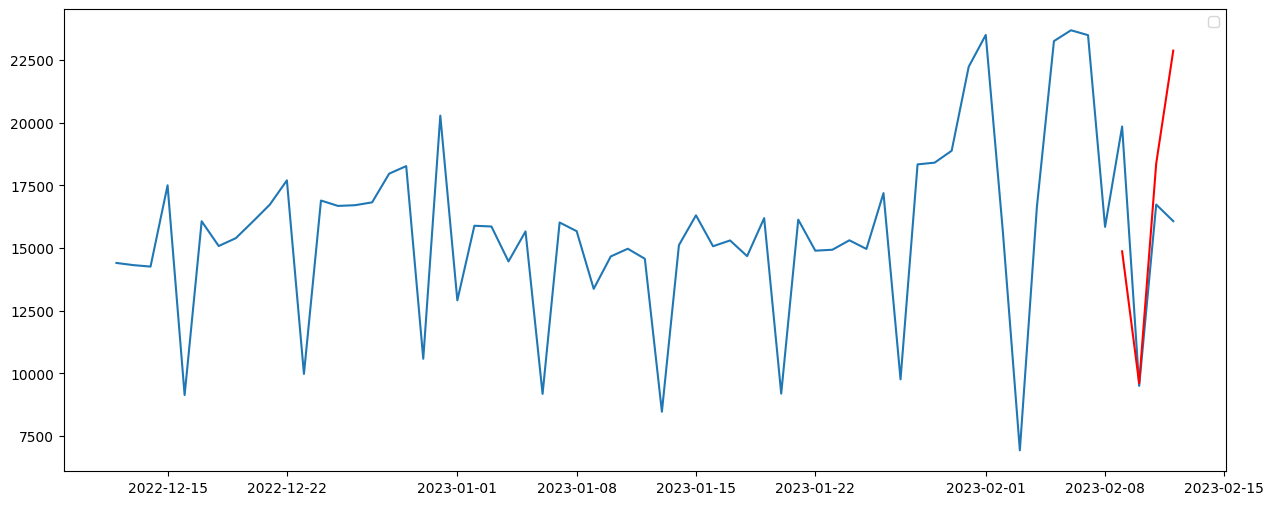

In [307]:
plt.figure(figsize=(15, 6))
plt.plot(X)
plt.plot(test_preds, color='red')
plt.legend()

In [308]:
models_stats

,Model,Mean Squared Error
0,AR,3.580635e+07
1,ARIMA,3.985803e+07
2,SARIMA,2.491012e+07
3,SARIMA 2,1.845268e+07


According to the models stats, we will be using SARIMA 2 as a final model